Bigram or more generally n- gram models have long been tested and used for statistical language modelling. The core idea behind them is to find the probability distribution of a certain sequence of words that occur. They highlight an important feature, words/chars that are near have higher statistical influence on the follower.

However, this approach is unscalable - since the as no. of characters under consideration increases, our distributions quickly move to higher dimensions.

Also, this approach has the following shortcomings --

1) it doesnt consider more than 1 or 2 predecessors.

2)it doesnt take into account the similarity between words under contexts.

[This paper(2003)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) highlights all the problems and proposes an improvement to our neural net approach by adding more layers.
Here, in this notebook we aim to mimic this approach and try to understand it in great detail.


Proposed architecture in paper.
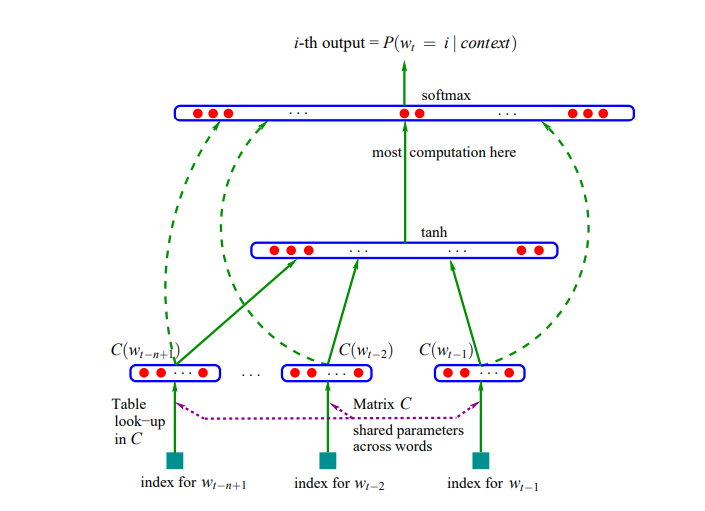

In [48]:
#importing required libraries
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
#lets code!
words=open('names.txt','r').read().splitlines()
type(words)

list

In [50]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}

stoi['.']=0
itos={i:s for s,i in stoi.items()}
itos #dictionary
itos[1]

'a'

In [51]:
#building dataset
X,Y=[],[]
block_size=3
for w in words:
 context=[0]*block_size
 #print(w)
 for ch in w+'.': # . 'dot' is added to capture last 3 characters 
  ix=stoi[ch]
  X.append(context)
  Y.append(ix)
  #print(''.join(itos[i] for i in context), '--->', itos[ix])
  context=context[1:] + [ix]
X=torch.tensor(X)
Y=torch.tensor(Y)


In [52]:
X.shape

torch.Size([228146, 3])

*An embedding is a mapping of a discrete — categorical — variable to a vector of continuous numbers*

In the context of neural networks, embeddings are low-dimensional, learned continuous vector representations of discrete variables. Neural network embeddings are useful because they can reduce the dimensionality of categorical variables and meaningfully **represent categories in the transformed space.**

For eg - Imagine going into a library with more than 1000 books. How do you expect the books to be grouped? One of many possible ways is to have language wise sections(here consider only 2 languages Hindi & english) with each sections having 2 types - fiction , non fiction, self help. 

So essentially to find one book you need 2 pieces of information - `language,type`. Voila, we have sucessfully reduced 1000 dim vector containing books into group of points in a custom 4d space, 1 axis for language other 3 for types. 

The operation of one-hot encoding categorical variables is actually a simple embedding where each category is mapped to a different vector. However, it doesn't help in reducing dimensionality niether does it help us find correlations b/w different types. 

Moreover, embeddings are a trainable measure.

**We will now introduce a lookup table C(embedding layer) for our dataset.**

In [53]:
C = torch.randn((27,2))

Why have we chosen the embedding matrix as 27x2 and what does it signify anyway?

Understand carefully,
we have (say) n words each made up of 3 chars. When we embed it to a lower dimensional space we are basically providing it with some features. Mapping to a 27x2 space means 

* we take dataset of words and assign each of its constituent a `2 d feature vector`. Lookup matrix could have been of 27 rows because there are 27 distict constituents. It can have 50 rows or maybe 1 million so to say but indexing will only yield 27 distict feature vectors rendering other rows useless.

for eg - `emb=C[X]`, where X is 32x3 (32 words each of 3 characters). emb will be a 32x3x2 tensor. 

Take **X[0]=(1,3,12)**, `emb[0] = (f_vec(1),f_vec(2),f_vec(12))` <- where f_vec(i) is feature vector of ith row from lookup table C i.e C(i)


In [54]:
emb = C[X]
emb

tensor([[[ 1.4802,  2.3041],
         [ 1.4802,  2.3041],
         [ 1.4802,  2.3041]],

        [[ 1.4802,  2.3041],
         [ 1.4802,  2.3041],
         [-0.2325, -0.2475]],

        [[ 1.4802,  2.3041],
         [-0.2325, -0.2475],
         [-0.9419,  0.6275]],

        ...,

        [[-0.5778, -1.2109],
         [-0.5778, -1.2109],
         [ 0.7274, -2.3252]],

        [[-0.5778, -1.2109],
         [ 0.7274, -2.3252],
         [-0.5778, -1.2109]],

        [[ 0.7274, -2.3252],
         [-0.5778, -1.2109],
         [ 0.1288,  0.2463]]])

In [55]:
emb.shape # 32 words, each made up of 3 letters, each letter associated with a 2 d feature/categorisation vector

torch.Size([228146, 3, 2])

We reduce all words to a base case of 3feature vectors each with 2 dimensions. Essentially, we embed from n dim space to a 6 dim space. Now, further operations we be done on this layer.

In [56]:
g= torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6,100), generator = g, requires_grad=True)
b1 = torch.randn(100, generator = g )
Z=torch.unbind(emb,1)


UNBIND function is used to remove a dimension internally. It returns a list. 

unbinding a `[32x3x2]` tensor along dim 1 returns a tuple with 3 `[32x2]` tensors. We can then conctenate these 3 tensors to get `[32x6]` dim tensor(matrix)

In [57]:
c_emb=torch.cat(torch.unbind(emb,1),1)
#concatenation creates whole new storage

`c_emb` can now be used to perform weight and bias calculations. However, there is a better way to reorganise emb tensor.

**32x3x2--> 32x6**. 

Due to internal structuring of Pytorch, keeping the product of dimensions same we can reorganise that tensor into any dimensional tensor. This is because tensor in memory is stored as a 1d vector and calling `.view()` plays around with pointers that (without disturbing the memory) simply creates divisions of some sort...

`.view()` is faster than other methods so we prefer it here over other ways (like concatenation as illustrated above!)

In [58]:
h= emb.view(-1,6)@W1 + b1 # we now enter the first hidden layer. It contains 100 neurons.
h.shape

torch.Size([228146, 100])

In [59]:
"""
h=torch.tanh(h)
W2 = torch.randn((100,27), generator = g, requires_grad=True)
b2 = torch.randn(27, generator = g)
logits = h@W2 + b2
counts = logits.exp()
probs= counts/counts.sum(1,keepdims=True)
loss = -probs[torch.arange(32),Y].log().mean() #probs(torch.arange(32),Y) what does this do?
loss
W1.grad=None
W2.grad=None
loss.item()
"""

'\nh=torch.tanh(h)\nW2 = torch.randn((100,27), generator = g, requires_grad=True)\nb2 = torch.randn(27, generator = g)\nlogits = h@W2 + b2\ncounts = logits.exp()\nprobs= counts/counts.sum(1,keepdims=True)\nloss = -probs[torch.arange(32),Y].log().mean() #probs(torch.arange(32),Y) what does this do?\nloss\nW1.grad=None\nW2.grad=None\nloss.item()\n'

This loss is known as cross_entropy!

`counts = logits.exp()`
 
 `probs= counts/counts.sum(1,keepdims=True)`
 
  `loss = -probs[torch.arange(32),Y].log().mean()` 
  
  `#probs(torch.arange(32),Y) what does this do?`

In [60]:
C = torch.randn((27,2))
g= torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6,100), generator = g, requires_grad=True)
b1 = torch.randn(100, generator = g )
W2 = torch.randn((100,27), generator = g, requires_grad=True)
b2 = torch.randn(27, generator = g)

"""
for i in range (100):
#forward pass
 h= emb.view(-1,6)@W1 + b1
 h=torch.tanh(h)
 logits = h@W2 + b2
 loss=F.cross_entropy(logits,Y)
 print(loss.item())
 W1.grad=None
 W2.grad=None
 loss.backward()
 W1.data += -0.21 * W1.grad
 W2.data += -0.21 * W2.grad
 """

'\nfor i in range (100):\n#forward pass\n h= emb.view(-1,6)@W1 + b1\n h=torch.tanh(h)\n logits = h@W2 + b2\n loss=F.cross_entropy(logits,Y)\n print(loss.item())\n W1.grad=None\n W2.grad=None\n loss.backward()\n W1.data += -0.21 * W1.grad\n W2.data += -0.21 * W2.grad\n '

Why we prefer F.cross_entropy??

1) It consumes less space (step by step implementation creates more tensors)

2) Mathematically the backward pass function is cleaner and easily implementable

3) Numerical stability 

for eg. say we have logits=`{[-1043,-3,2,100]}`
for very -ve no. exponential returns very small values(near to zero or zero). However, for very large numbers it blows up and starts returning nan(or inf)  

To tackle this F.cross_entroy subtarcts the largest entry in logits from every entry, then performs softmax -- which due to nature of softmax yields same result. This prevents no. from blowing up to nan!

In [61]:
logits_test=torch.tensor([1,1,-100,100,-560])
logits_test.exp()

tensor([2.7183e+00, 2.7183e+00, 3.7835e-44,        inf, 0.0000e+00])

In [62]:
logits_test=torch.tensor([1,1,-100,100,-560]) - 100 #what pytorch internally does
logits_test.exp()

tensor([1.0089e-43, 1.0089e-43, 0.0000e+00, 1.0000e+00, 0.0000e+00])

So far we have been backproped and changed the weight matrices only keeping of trainable entries untouched (embeddings, biases). We call all trainable measures as parameters. We will now perform backprop for all params for better model.

In [63]:
params=[C,W1,b1,W2,b2] # we travel layer by layer
for p in params:
  p.requires_grad=True

In [64]:
sum(p.nelement() for p in params)


3481

In [65]:
"""
for i in range (100):
 emb = C[X]
 h= emb.view(-1,6)@W1 + b1
 h=torch.tanh(h)
 logits = h@W2 + b2
 loss=F.cross_entropy(logits,Y)
 for p in params: #backprop
   p.grad=None
 loss.backward()
 for p in params:
   p.data+= -0.1 * p.grad #gradient descent
print(loss.item())
"""

'\nfor i in range (100):\n emb = C[X]\n h= emb.view(-1,6)@W1 + b1\n h=torch.tanh(h)\n logits = h@W2 + b2\n loss=F.cross_entropy(logits,Y)\n for p in params: #backprop\n   p.grad=None\n loss.backward()\n for p in params:\n   p.data+= -0.1 * p.grad #gradient descent\nprint(loss.item())\n'

In [66]:
(torch.randint(0,X.shape[0],(32,)))#generating a tensor of 32 random numbers between 0 and total no of words

tensor([ 52915, 187609,  45706,  26755, 180962,  30379,  40642, 144010, 140944,
         40301,  51900,  63539,  84418, 189674,  80806, 100453,  76572,  91614,
        154698, 150322,  43668,  78085,  11393, 166576, 219714, 121859, 197008,
        148847, 197436,  95860,  75159,  52629])

In [67]:
lre=torch.linspace(-3,1,1000)
lrs=10**lre

In [68]:
lri=[]
lossi=[]
for i in range (1000):
 #mini batch construct
 lr=lrs[i]
 ix=torch.randint(0,X.shape[0],(32,)) #tensor of 32 random numbers.
 emb = C[X[ix]]
 h= emb.view(-1,6)@W1 + b1
 h=torch.tanh(h)
 logits = h@W2 + b2
 loss=F.cross_entropy(logits,Y[ix])
 for p in params: #backprop
   p.grad=None
 loss.backward()
 for p in params:
   p.data+= -lr * p.grad #gradient descent
 lri.append(lre[i])
 lossi.append(loss.item())


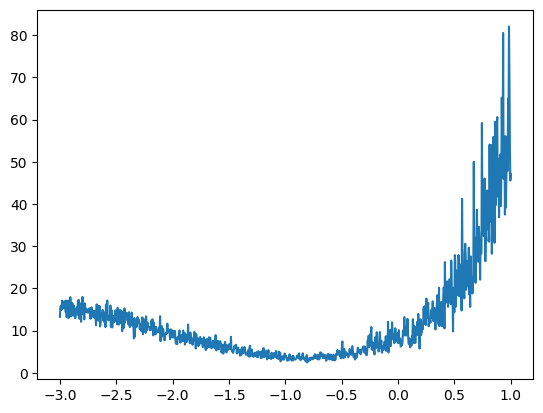

In [69]:
plt.plot(lri,lossi) #learning rate exponent vs loss

we observe a minimum somewhere around zero i.e lr= 10^(0+e), where e is a very small no. lr will fluctuate depending on training. (you can run iterations and see for yourself. We however stick to lr=-0.1 for initial runs!!

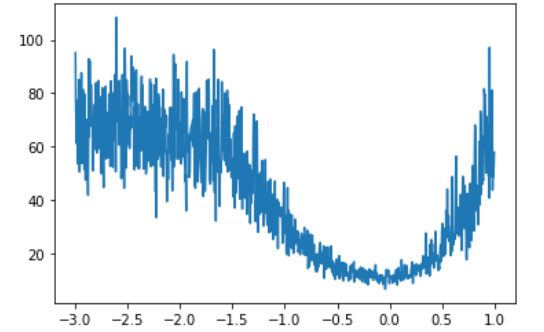
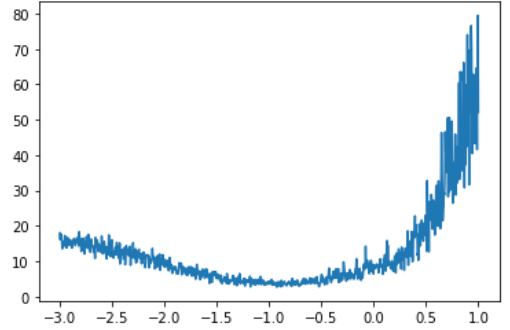

In [70]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

C = torch.randn((27,2))
emb = C[Xtr]
g= torch.Generator().manual_seed(2147483647)
W1 = torch.randn((6,100), generator = g, requires_grad=True)
b1 = torch.randn(100, generator = g )
W2 = torch.randn((100,27), generator = g, requires_grad=True)
b2 = torch.randn(27, generator = g)
lre=torch.linspace(-3,1,1000)
lrs=10**lre
lri=[]
lossi=[]
for i in range (1000):
 #mini batch construct
 lr=lrs[i]
 ix=torch.randint(0,Xtr.shape[0],(32,)) #tensor of 32 random numbers.
 emb = C[Xtr[ix]]
 h= emb.view(-1,6)@W1 + b1
 h=torch.tanh(h)
 logits = h@W2 + b2
 loss=F.cross_entropy(logits,Ytr[ix])
 for p in params: #backprop
   p.grad=None
 loss.backward()
 for p in params:
   p.data += -0. 01 *p.grad #gradient descent
 lri.append(lre[i])
 lossi.append(loss.item())

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


TypeError: ignored